In [1]:
import cv2,math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread('./test.jpg')
#img = cv2.imread('./cmcc.png')
h,w,c = img.shape

## BGR to GRAY

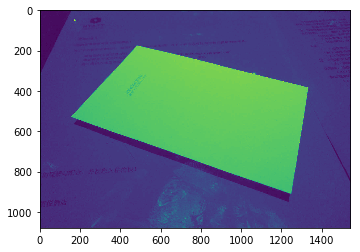

In [17]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#cv2.imwrite('./gray.jpg',img_gray)
plt.imshow(img_gray)

## Edge detection

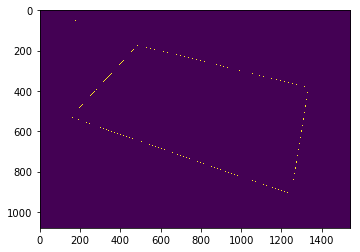

In [18]:
img_edge = cv2.Canny(img_gray,300,600)
#cv2.imwrite('./edge.jpg',img_edge)
plt.imshow(img_edge)

## Line detection 

[[[ 153  528  483  175]]

 [[ 588  199 1328  383]]

 [[ 816  763 1243  911]]

 [[ 282  576  721  728]]

 [[1245  909 1292  614]]

 [[1246  906 1328  388]]

 [[ 207  549  617  691]]

 [[ 417  244  481  175]]]


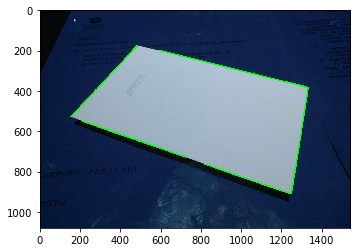

In [19]:
lines = cv2.HoughLinesP(img_edge, 1.0, np.pi/180, 100, minLineLength=0, maxLineGap=50)
print lines

tmp = img.copy()
for line in lines:
    [xmin,ymin,xmax,ymax] = line[0]
    cv2.line(tmp,(xmin,ymin),(xmax,ymax),(0,255,0),5)
plt.imshow(tmp)

## Get the longest line

In [6]:
length_list = []
for line in lines:
    [xmin,ymin,xmax,ymax] = line[0]
    #print line
    length = math.sqrt(pow((xmax - xmin),2) + pow((ymax - ymin),2))
    length_list.append((line[0],length))
longest = sorted(length_list, key=lambda item:item[1] ,reverse=True)[0][0]
print longest

[ 588  199 1328  383]


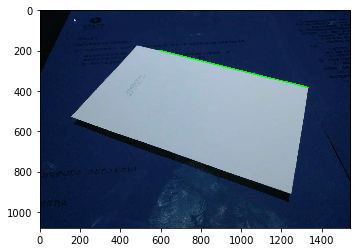

In [7]:
[xmin,ymin,xmax,ymax] = longest
tmp = img.copy()
cv2.line(tmp,(xmin,ymin),(xmax,ymax),(0,255,0),5)
plt.imshow(tmp)

## Get the rotation angle

In [8]:
angle = math.degrees(math.atan2(longest[3]-longest[1],longest[2]-longest[0]))
print angle

13.9633481135


## Padding image 

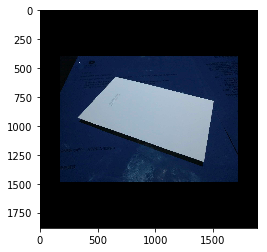

In [9]:
diagonal = int(math.sqrt(pow(w,2) + pow(h,2)))
img_padded = cv2.copyMakeBorder(img, 
                                int((diagonal-h)/2)+1, 
                                int((diagonal-h)/2)+1, 
                                int((diagonal-w)/2)+1, 
                                int((diagonal-w)/2)+1, 
                                cv2.BORDER_CONSTANT, value=(0,0,0))
#cv2.imwrite('./padded.jpg',img_padded)
plt.imshow(img_padded)

## Rotate image 

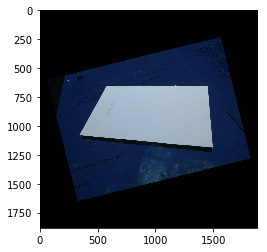

In [10]:
M = cv2.getRotationMatrix2D((diagonal/2,diagonal/2), angle, 1)
img_rotated = cv2.warpAffine(img_padded, M, (diagonal,diagonal))
#cv2.imwrite('./rotated.jpg',img_rotated)
plt.imshow(img_rotated)

## Perspective Transform 

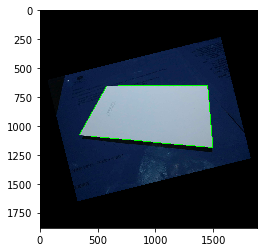

In [11]:
img_gray = cv2.cvtColor(img_rotated,cv2.COLOR_BGR2GRAY)
img_edge = cv2.Canny(img_gray,300,600)
lines = cv2.HoughLinesP(img_edge, 1.0, np.pi/180, 100, minLineLength=0, maxLineGap=50)

tmp = img_rotated.copy()
for line in lines:
    [xmin,ymin,xmax,ymax] = line[0]
    cv2.line(tmp,(xmin,ymin),(xmax,ymax),(0,255,0),5)
plt.imshow(tmp)

In [13]:
points= []
for line in lines:
    [xmin,ymin,xmax,ymax] = line[0]
    points.append((xmin,ymin))
    points.append((xmax,ymax))
print points

[(672, 654), (756, 654), (736, 653), (1081, 653), (444, 1090), (879, 1129), (340, 1078), (574, 656), (1048, 1147), (1489, 1186), (1446, 656), (1491, 1174), (1027, 654), (1445, 654), (339, 1078), (484, 817), (843, 1126), (1042, 1146), (1447, 662), (1471, 939), (1469, 928), (1491, 1185)]


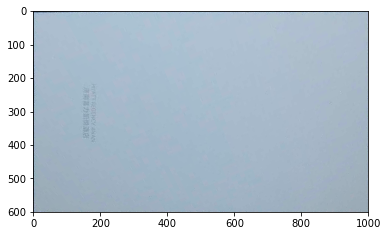

In [14]:
pts1 = np.float32([[574,654],[1445,654],[339,1078],[1491,1185]])
pts2 = np.float32([[0,0],[1000,0],[0,600],[1000,600]])
tmp = img_rotated.copy()
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(tmp,M,(1000,600))
plt.imshow(dst)
#cv2.imwrite('./dst.jpg',dst)